# Assignment 3

Gender: Gender of the individual

Age: Age of the individual

Height: Height of the individual

Weight: Weight of the individual

family_history_with_overweight: Whether the individual has a family member suffered or suffers from overweight

FAVC: Frequency of consuming high-calorie foods

FCVC: Frequency of of consuming vegetables

NCP: Number of main meals per day

CAEC: Frequency of eating any food between meals

SMOKE: Whether the individual smoke

CH2O: Amount of water consumed daily

SCC: Whether the individual monitors their daily calories

FAF: Frequency of having physical activity

TUE: Time using technological devices (cell phone, videogames, television, computer and others)

CALC: Frequency of consuming alcohol

MTRANS: Mode of transportation used by the individual (e.g., walking, biking, public transportation, etc.).

NObeyesdad: Obesity level

**Class Labels**

Insufficient Weight, Normal Weight, Overweight Level I, Overweight Level II, Obesity Type I, Obesity Type II, and Obesity Type III

**Research Questions**:

1. Can we predict an individual's obesity level based on their eating habits and physical condition?

1. What are the key factors that influence obesity levels in individuals? 

1. What is the effect of the most important predictors

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical


seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

In [57]:
DATA_DIR = "ObesityDataSet_raw_and_data_sinthetic.csv"
df = pd.read_csv(DATA_DIR)
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


## Read Data to dataframe and convert to categorical 

In [63]:

object_columns = df.select_dtypes(include=['object']).columns
bool_columns = df.select_dtypes(include=['bool']).columns

df[object_columns] = df[object_columns].astype('category')
df[bool_columns] = df[bool_columns].astype('category')
df_map_dict = {}

for col in df.select_dtypes(['category']).columns:
    df_map_dict[col] = dict(enumerate(df[col].cat.categories))
inverse_df_map_dict = {col: {v: k for k, v in df_map_dict[col].items()} for col in df_map_dict}

df[object_columns] = df[object_columns].apply(lambda x: x.cat.codes)
df[bool_columns] = df[bool_columns].apply(lambda x: x.cat.codes)

df.head()

X = df.drop('NObeyesdad', axis=1)
y = df['NObeyesdad']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)


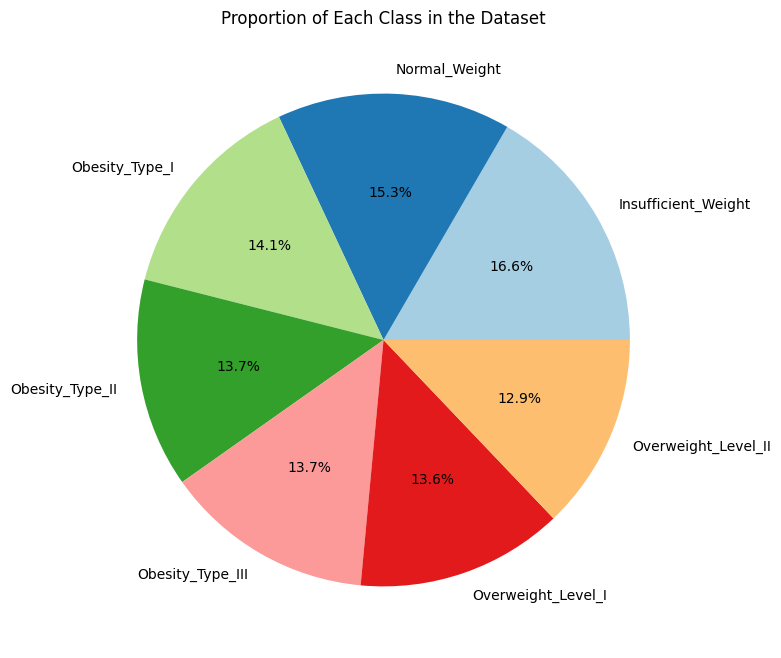

In [6]:
class_proportion = df['NObeyesdad'].value_counts(normalize=True) * 100

# print(class_proportion)
plt.figure(figsize=(10, 8))
class_proportion.plot(kind='pie', autopct='%1.1f%%', 
                      colors=plt.cm.Paired.colors, 
                      labels=inverse_df_map_dict['NObeyesdad'])
plt.title('Proportion of Each Class in the Dataset')
plt.ylabel('')
plt.show()

## Check data correlation

## 2d Projection (Will not be used)

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
tsne = TSNE(n_components=2, random_state=seed)
X = X_train + X_test
X_embedded = tsne.fit_transform(X_train)
plt.figure(figsize=(10, 6))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y_train)
plt.colorbar()
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization of the Dataset')
plt.show()

## Normalize the data

In [70]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### Method 1: Logistic Regression

The coefficients of the logistic regression model indicate the importance and influence of each feature on the obesity levels.

This helps identify which factors are significant predictors of obesity.

In [71]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic', LogisticRegression(max_iter=1000, random_state=42))
])

param_grid = {
    'logistic__C': [0.001, 0.01, 0.1, 1, 10, 100],  
    'logistic__penalty': ['l2'],  
    'logistic__solver': ['lbfgs']  
}

grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, verbose=1, scoring='accuracy',  n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

print("Best Parameters:", grid_result.best_params_)
print("Best Score:", grid_result.best_score_)

best_params = grid_result.best_params_

best_log_reg = LogisticRegression(max_iter=1000, random_state=seed, C=best_params['logistic__C'], penalty=best_params['logistic__penalty'])

best_log_reg.fit(X_train, y_train)

y_pred_log = best_log_reg.predict(X_test)

print("\nLogistic Regression\n")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print("Classification Report:\n", classification_report(y_test, y_pred_log))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_log))
print("Coefficients:\n", pd.DataFrame(best_log_reg.coef_.T, X.columns, columns=best_log_reg.classes_))


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameters: {'logistic__C': 100, 'logistic__penalty': 'l2', 'logistic__solver': 'lbfgs'}
Best Score: 0.9431241410902427

Logistic Regression

Accuracy: 0.9652996845425867
Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.97        86
           1       0.98      0.90      0.94        93
           2       0.99      0.98      0.99       102
           3       0.97      1.00      0.98        88
           4       1.00      0.99      0.99        98
           5       0.92      0.94      0.93        88
           6       0.96      0.94      0.95        79

    accuracy                           0.97       634
   macro avg       0.96      0.96      0.96       634
weighted avg       0.97      0.97      0.97       634

Confusion Matrix:
 [[ 86   0   0   0   0   0   0]
 [  6  84   0   0   0   3   0]
 [  0   0 100   2   0   0   0]
 [  0   0   0  88   0   0   0]


In [68]:
y.nunique()

7

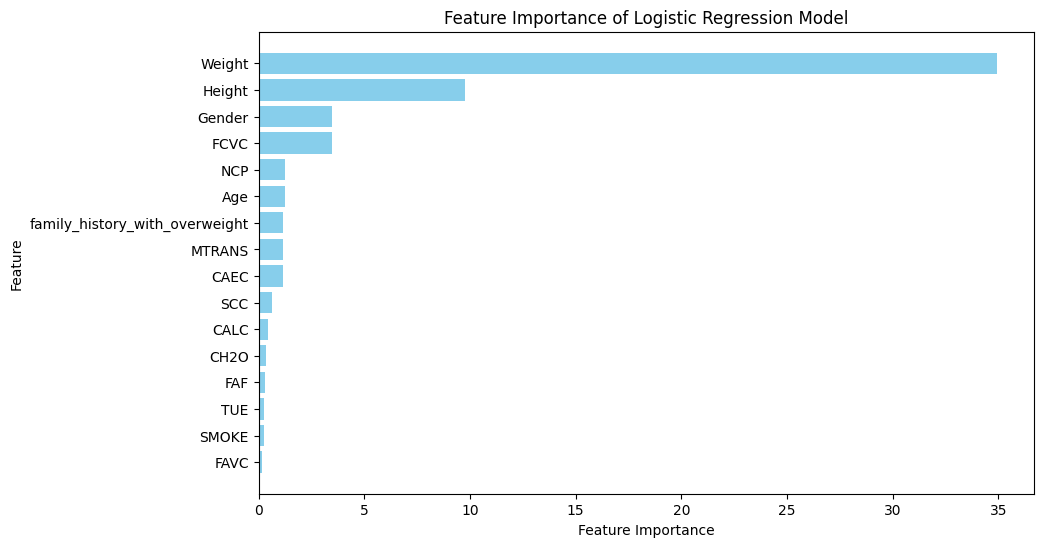

In [72]:

total_coefficients = np.sum(np.abs(best_log_reg.coef_), axis=0)/y.nunique()
sorted_indices = np.argsort(total_coefficients)
sorted_coefficients = total_coefficients[sorted_indices]
sorted_feature_names = X.columns[sorted_indices]

plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_coefficients, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance of Logistic Regression Model')
plt.show()

##### **marginal effect**

#### Method 2: Random Forest Classifier

The feature importance scores from the random forest model highlight the key factors influencing obesity levels.

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Random Forest Classifier

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Score: 0.9553252404947321
Accuracy:
 0.9479495268138801

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.95      0.97        86
           1       0.82      0.96      0.89        93
           2       0.98      0.96      0.97       102
           3       0.97      0.99      0.98        88
           4       1.00      0.99      0.99        98
           5       0.93      0.85      0.89        88
           6       0.97      0.92      0.95        79

    accuracy                           0.95       634
   macro avg       0.95      0.95      0.95       634
weighted avg       0.95      0.95      0.95       634


Confusion Matrix:
 [[82  4  0  0  0  0  0]
 [ 1 89  0  0  0  3  0]
 [ 0  1 98  3  0  0  0]
 [ 0  0  1 87  0  0  0]
 [ 0  0

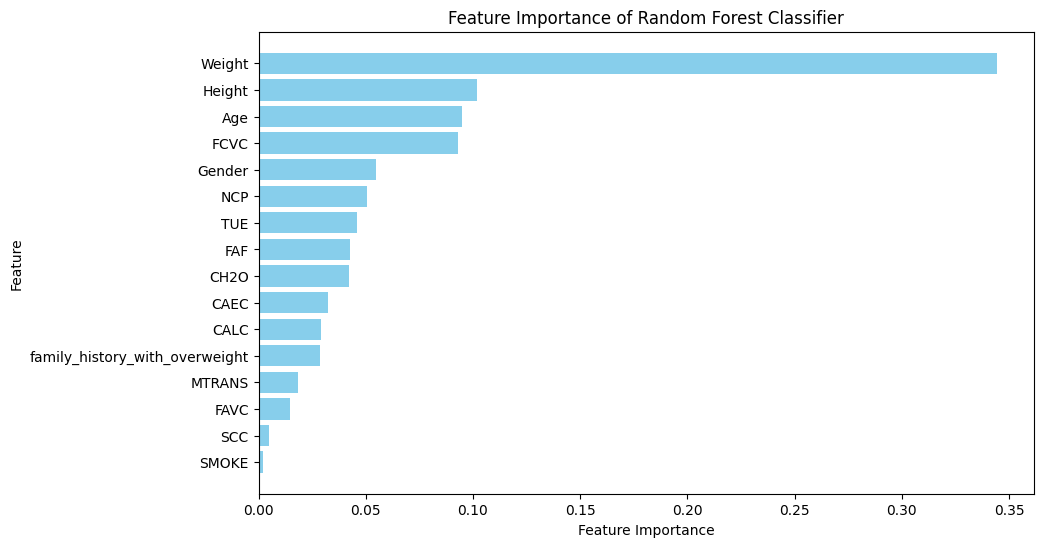

In [8]:
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}

rf_clf = RandomForestClassifier(random_state=seed)

grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Random Forest Classifier\n")
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

y_pred_rf = grid_search.predict(X_test)

print("Accuracy:\n",accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))
print("\nConfusion Matrix:\n",confusion_matrix(y_test, y_pred_rf))

best_rf_clf = grid_search.best_estimator_
feature_importance = pd.DataFrame(best_rf_clf.feature_importances_, index=X.columns, columns=['Importance']).sort_values('Importance', ascending=False)
feature_importance_asc = feature_importance.sort_values('Importance', ascending=True)
print("\nFeature Importance:\n", feature_importance)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_asc.index, feature_importance_asc['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance of Random Forest Classifier')
plt.show()

#### Method 3: Support Vector Machine

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Best Score: 0.9512551534585432

SVM Classifier

Accuracy: 0.9794952681388013

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98        86
           1       1.00      0.97      0.98        93
           2       0.99      0.97      0.98       102
           3       0.97      1.00      0.98        88
           4       1.00      0.99      0.99        98
           5       0.98      0.97      0.97        88
           6       0.95      0.96      0.96        79

    accuracy                           0.98       634
   macro avg       0.98      0.98      0.98       634
weighted avg       0.98      0.98      0.98       634


Confusion Matrix:
 [[86  0  0  0  0  0  0]
 [ 3 90  0  0  0  0  0]
 [ 0  0 99  2  0  0  1]
 [ 0  0  0 88  0  0  0]
 [ 0  0  0  1 97  0  0]
 [ 0  0  0  0  0 85  3]
 [ 0  0  1

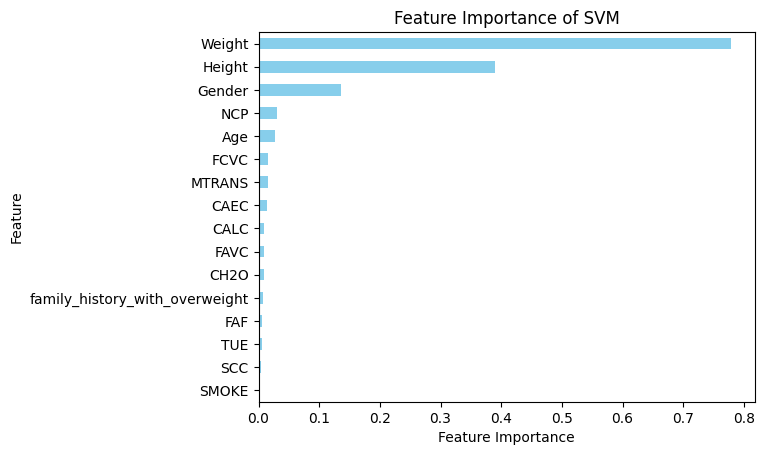

In [9]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],  # Regularization parameter
    'kernel': ['linear', 'rbf'],  # Kernel type
    'gamma': ['scale', 'auto']  # Kernel coefficient for 'rbf' kernel
}

svm_clf = SVC(random_state=seed)

grid_search = GridSearchCV(estimator=svm_clf, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

best_svm_clf = grid_search.best_estimator_
y_pred_svm = best_svm_clf.predict(X_test)

print("\nSVM Classifier\n")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))

result_svr = permutation_importance(best_svm_clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
sorted_idx = result_svr.importances_mean
feat_names = list(X.columns)

importance = pd.DataFrame(sorted_idx, index=feat_names, columns=['Importance'])
importance.sort_values(by='Importance', ascending=True).plot(kind='barh', title='Feature Importance of SVM', color='skyblue', legend=False)
plt.ylabel('Feature')
plt.xlabel('Feature Importance')
plt.show()

In [44]:
importance = importance.sort_values(by='Importance', ascending=False)
importance

,Importance
Weight,0.778549
Height,0.389748
Gender,0.135804
NCP,0.029653
Age,0.026498
FCVC,0.015773
MTRANS,0.014984
CAEC,0.014038
CALC,0.009621
FAVC,0.008991


In [47]:
svr_list = [i for i in importance[:4].index]
print(svr_list)

['Weight', 'Height', 'Gender', 'NCP']


In [53]:
X_train[3, :].min()

-4.0834132977077715

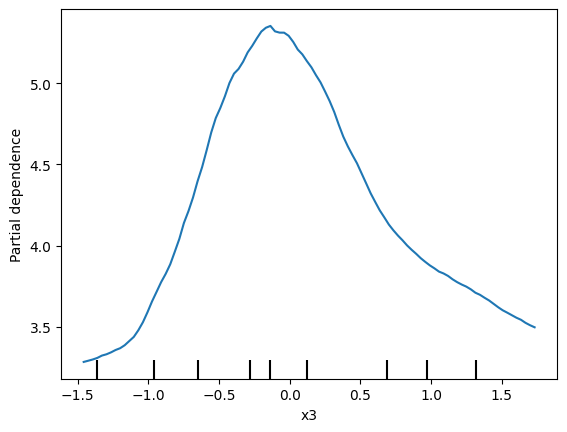

In [56]:
svc_partial = PartialDependenceDisplay.from_estimator(best_svm_clf, X_train, features=[3], target=6)

#### Method 4: Neural Network

In [ ]:
len(y.unique())

In [ ]:
# from sklearn.preprocessing import LabelEncoder

# label_encoder = LabelEncoder()
# y_train_encoded = label_encoder.fit_transform(y_train)

y_train_onehot = to_categorical(y_train)

model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='leaky_relu'))
model.add(Dense(32, activation='leaky_relu'))
model.add(Dense(16, activation='leaky_relu'))
model.add(Dense(len(y.unique()), activation='softmax'))
optimizer = tf.keras.optimizers.AdamW(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.summary()

history = model.fit(X_train, y_train_onehot, epochs=100, batch_size=4, validation_split=0.2, verbose=1)

# model.save('obesity_model.h5')

y_pred_nn = model.predict(X_test)
y_pred_nn_classes = y_pred_nn.argmax(axis=1)

print("\nNeural Network\n")
print("\nAccuracy:", accuracy_score(y_test, y_pred_nn_classes))
print("\nClassification Report:\n", classification_report(y_test, y_pred_nn_classes))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_nn_classes))

# weights = model.layers[0].get_weights()[0]

# feature_importance = abs(weights).sum(axis=1)

# feature_names = X.columns

# sorted_indices = feature_importance.argsort()[::-1]
# sorted_feature_importance = feature_importance[sorted_indices]
# sorted_feature_names = feature_names[sorted_indices]

# plt.figure(figsize=(10, 6))
# plt.barh(sorted_feature_names[:15], sorted_feature_importance[:15], color='skyblue')
# plt.xlabel('Feature Importance')
# plt.ylabel('Feature')
# plt.title('Feature Importance of Neural Network Model')
# plt.gca().invert_yaxis() 
# plt.show()

In [ ]:
# use permutation importance with the keras model 

result_nn = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1, scoring='accuracy')
sorted_idx = result_nn.importances_mean
feat_names = list(X.columns)

importance = pd.DataFrame(sorted_idx, index=feat_names, columns=['Importance'])
importance.sort_values(by='Importance', ascending=True).plot(kind='barh', title='Feature Importance of Neural Network', color='skyblue', legend=False)
plt.ylabel('Feature')
plt.xlabel('Feature Importance')
plt.show()